
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

### Universidad Nacional de Córdoba
---

## Practico
### Curación y Exploración de Datos

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Exploración y Curación. El objetivo consiste en identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad y validando el sentido lógico. 

Dataset: [here](https://drive.google.com/file/d/1wCNrWQbUd_bh1mdjZ-dg3g9y0r02JyQN/view?usp=sharing)

## Importación de Librerías

In [1]:
import pyarrow
import fastparquet
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib as hl
import re

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import (base, decomposition, feature_extraction, impute,
                     neighbors, preprocessing)
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode


pd.set_option('display.max_columns', None)

In [2]:
!pip install unidecode

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


## Lectura de Datasets

In [3]:
df_orig = pd.read_parquet("cupones_ds.parquet")
df = df_orig

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092077 entries, 0 to 4092076
Data columns (total 41 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   dni_titular_movimiento               object 
 1   moneda_movimiento                    int64  
 2   id_comercio_movimiento               int64  
 3   nombre_comercio_histo                object 
 4   numero_cupon_movimiento              int64  
 5   debito_credito_movimiento            int64  
 6   producto_naranja_movimiento          object 
 7   codigo_empresa_movimiento            int64  
 8   tipo_producto_tarjeta_movimiento     int64  
 9   plan_movimiento                      int64  
 10  fecha_vto_cupon_movimiento           object 
 11  fecha_presentacion_movimiento        object 
 12  fecha_cupon_movimiento               object 
 13  fecha_carga_sistema_movimiento       object 
 14  monto_compra_movimiento              float64
 15  importe_cuota_movimiento        

Antes de iniciar la curación, se deben tener en cuenta dos factores importantes a la hora del análisis de los montos: El efecto de la inflación y el tipo de cambio.

### Ajuste por Inflación

Fuente: https://datosmacro.expansion.com/ipc-paises/argentina?sector=IPC+General&sc=IPC-IG&anio=2020

Como los consumos en pesos fueron efectuados durante ciertos meses, sumarlos en diferentes momentos temporales nos puede llevar a sacar conclusiones incorrectas. Obtuvimos los datos de inflación mensual de la fuente mencionada y aplicamos sobre las diferentes filas afectadas. Elegimos como mes base, el mes de Febrero del 2020, llevando todos los movimientos a la moneda de ese mes.

In [5]:
df_infl = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Indices%20de%20inflaci%C3%B3n.csv', 
                      parse_dates=['mes'])

In [6]:
df_infl

,mes,inflacion_mensual,inflacion_acumulada
0,2020-02-01,0.000,0.000
1,2020-03-01,0.033,0.033
2,2020-04-01,0.015,0.048
3,2020-05-01,0.015,0.063
4,2020-06-01,0.022,0.085
5,2020-07-01,0.019,0.104
6,2020-08-01,0.027,0.131
7,2020-09-01,0.028,0.159
8,2020-10-01,0.038,0.197
9,2020-11-01,0.032,0.229


In [7]:
df['anio_mes_cupon'] = pd.DatetimeIndex(df['fecha_cupon_movimiento']).year * 100 + pd.DatetimeIndex(df['fecha_cupon_movimiento']).month

In [8]:
df_infl['anio_mes_infl'] = pd.DatetimeIndex(df_infl['mes']).year * 100 + pd.DatetimeIndex(df_infl['mes']).month

In [9]:
df = df.merge(df_infl[['anio_mes_infl', 'inflacion_acumulada']]
         ,left_on='anio_mes_cupon'
         ,right_on='anio_mes_infl'
         ,how='inner').drop(columns=['anio_mes_infl'])
df.loc[df.moneda_movimiento != 1,'monto_ajustado'] = \
                df[df.moneda_movimiento != 1]['monto_compra_movimiento'] / (1 + df['inflacion_acumulada'])

### Ajuste por Tipo de Cambio

Fuente: https://www.bna.com.ar/ (Buscar historicos de cotizaciones)

Sabemos que no se pueden sumar movimientos en diferentes divisas. Por lo tanto, decidimos aplicar el tipo de cambio vendedor a los montos en dólares presentes en el dataset. Sabemos que Tarjeta Naranja aplica, para esta conversión, el tipo de cambio del dia del pago del resumen. Hicimos la suposición de que los clientes abonaron el resumen a su vencimiento, el día 10 (o el primer dia hábil siguiente) de cada mes.

Es necesario aclarar que el cierre de la tarjeta se da los dias 24 de cada mes. Por lo tanto, los movimientos efectuados luego de esa fecha se abonan al mes subsiguiente.

In [10]:
df_tdc = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Tipos%20de%20cambio.csv',
                     parse_dates=['fecha_cotizacion'], dayfirst=True, delimiter=';')

In [11]:
df_tdc = df_tdc.sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc['anio_mes'] = (df_tdc.fecha_cotizacion.dt.year * 100) + df_tdc.fecha_cotizacion.dt.month
df_tdc.head(10)

,fecha_cotizacion,compra,venta,anio_mes
0,2020-02-10,58.00,63.00,202002
1,2020-02-11,58.25,63.25,202002
2,2020-02-12,58.25,63.25,202002
3,2020-02-13,58.25,63.25,202002
4,2020-02-14,58.25,63.25,202002
5,2020-02-17,58.25,63.25,202002
6,2020-02-18,58.25,63.25,202002
7,2020-02-19,58.50,63.50,202002
8,2020-02-20,58.50,63.50,202002
9,2020-02-21,58.50,63.50,202002


In [12]:
df_tdc['day'] = df_tdc.fecha_cotizacion.dt.day

In [13]:
meses_cdiez = df_tdc[df_tdc['day'].isin([10])]['anio_mes'].unique()
meses_sdiez = df_tdc[(~df_tdc['day'].isin([10])) & (~df_tdc['anio_mes'].isin(meses_cdiez))]['anio_mes'].unique()

ind_fechas = []

for i in meses_cdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] == 10)]['fecha_cotizacion'].index)))
for i in meses_sdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] > 10)]['fecha_cotizacion'].index)))

In [14]:
df_tdc_cot = df_tdc.iloc[ind_fechas,:].sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc_cot

,fecha_cotizacion,compra,venta,anio_mes,day
0,2020-02-10,58.00,63.00,202002,10
1,2020-03-10,59.00,64.00,202003,10
2,2020-04-13,61.75,66.75,202004,13
3,2020-05-11,64.25,69.25,202005,11
4,2020-06-10,66.50,71.50,202006,10
5,2020-07-13,69.50,74.50,202007,13
6,2020-08-10,72.00,77.00,202008,10
7,2020-09-10,74.00,79.00,202009,10
8,2020-10-13,76.25,82.25,202010,13
9,2020-11-10,78.75,84.75,202011,10


In [15]:
df.fecha_cupon_movimiento = pd.to_datetime(df.fecha_cupon_movimiento)

In [16]:
def func_var(row):
    if row.fecha_cupon_movimiento.day > 24:
        if row.fecha_cupon_movimiento.month == 12:
            return 202101
        else:
            return row['anio_mes_cupon'] + 1
    else:
        return row['anio_mes_cupon']

In [17]:
df.loc[df.moneda_movimiento == 1,'anio_mes_cupon'] = df[df.moneda_movimiento == 1].apply(func_var, axis=1)

In [18]:
df[df.moneda_movimiento == 1][['fecha_cupon_movimiento','anio_mes_cupon']].head(5)

,fecha_cupon_movimiento,anio_mes_cupon
3111,2020-08-02,202008
3120,2020-08-02,202008
3130,2020-08-02,202008
3196,2020-08-02,202008
3465,2020-08-07,202008


In [19]:
df[(df.moneda_movimiento == 1) & (df.fecha_cupon_movimiento.dt.day >= 25)  & (df.fecha_cupon_movimiento.dt.month >= 12)][['fecha_cupon_movimiento','anio_mes_cupon']].head(5)

,fecha_cupon_movimiento,anio_mes_cupon
1801620,2020-12-25,202101
1801621,2020-12-27,202101
1801627,2020-12-27,202101
1801636,2020-12-31,202101
1801649,2020-12-27,202101


In [20]:
df.anio_mes_cupon.unique()

array([202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103,
       202104, 202007, 202105, 202106, 202006, 202004, 202005, 202002],
      dtype=int64)

In [21]:
df = df.merge(df_tdc_cot[['anio_mes', 'venta']]
                 ,left_on='anio_mes_cupon'
                 ,right_on='anio_mes'
                 ,how='inner').drop(columns=['anio_mes'])

In [22]:
df.loc[df.moneda_movimiento == 1,'monto_ajustado'] = \
                df[df.moneda_movimiento == 1]['monto_compra_movimiento'] * df['venta']

In [23]:
df[df.moneda_movimiento == 1][['monto_compra_movimiento','monto_ajustado']]

,monto_compra_movimiento,monto_ajustado
3111,-3.50,-269.50
3120,-33.00,-2541.00
3130,-34.08,-2624.16
3196,-200.23,-15417.71
3465,0.16,12.32
...,...,...
4091520,-0.09,-9.00
4091521,-0.09,-9.00
4091522,-0.09,-9.00
4091523,-0.09,-9.00


In [24]:
# Se descartan las columnas usadas para los calculos
df = df.drop(columns=['anio_mes_cupon','inflacion_acumulada','venta']) 

In [25]:
df['monto_ajustado'] = df['monto_ajustado'].round(2)

In [26]:
# Montos ajustados en pesos
df.loc[df['moneda_movimiento'] != 1, ['monto_compra_movimiento','monto_ajustado']].describe().round(2)

,monto_compra_movimiento,monto_ajustado
count,4017026.00,4017026.00
mean,1996.50,1561.21
std,5862.34,4565.67
min,-147263.64,-123027.27
25%,75.02,58.98
50%,301.29,251.70
75%,1500.00,1183.64
max,220540.01,160281.96


In [27]:
# Montos ajustados en dolares
df.loc[df['moneda_movimiento'] == 1, ['monto_compra_movimiento','monto_ajustado']].describe().round(2)

,monto_compra_movimiento,monto_ajustado
count,75051.00,75051.00
mean,3.03,251.74
std,25.52,2236.15
min,-200.23,-19822.77
25%,1.10,95.41
50%,2.71,234.63
75%,5.14,438.13
max,325.35,25702.65


------

## 1 Curación

### 1.1. Asegurar IDs únicos

In [28]:
df['id_comercio_movimiento'].value_counts() # 3833 valores unicos para id_comercio

958705120    464301
20099902     415104
20089993     359283
20099745     239775
20099760     194994
              ...  
115052555        15
840017948        15
380028770        15
20101264         14
64194852          5
Name: id_comercio_movimiento, Length: 3833, dtype: int64

In [29]:
# Aca deberia haber 2 'TARJETA NARANJA SUBTE'

df[df['nombre_comercio_histo'].str.contains('TARJETA NARANJA SUBTE')] \
                                        [['id_comercio_movimiento','nombre_comercio_histo']] \
                                        .drop_duplicates()

,id_comercio_movimiento,nombre_comercio_histo
2527,10099033,TARJETA NARANJA SUBTE
10055,10099033,TARJETA NARANJA SUBTE


In [30]:
# Reagrupar los comercios que tienen mas de un nombre y concatenar todos sus nombres
df.nombre_comercio_histo = df.nombre_comercio_histo.str.strip()

df_unicos = (
    df[["id_comercio_movimiento", "nombre_comercio_histo"]].drop_duplicates()
        .groupby("id_comercio_movimiento")
        .sum()
).reset_index()

In [31]:
df_unicos = df_unicos.rename(columns={'nombre_comercio_histo':'nombre_comercio_concat'})
df_unicos

,id_comercio_movimiento,nombre_comercio_concat
0,10099033,TARJETA NARANJA SUBTE
1,10099058,TARJETA NARANJA SUCRE
2,10099814,TARJETA NARANJA SAN VICENTE
3,20080001,PAGO ANULADO POR VERIFICACION
4,20089993,IMPUESTO SELLOS
...,...,...
3828,991085968,PUERTO TERNURAS
3829,991097830,PEQUE&OS SUE&OS
3830,991108260,DISCO SM 156
3831,991108624,JUMBO MOR�N


Reagrupamos los comercios que tienen mas de un nombre y concatenamos todos sus nombres en una nueva columna **nombre_comercio_concat**

In [32]:
# Unimos con dataframe original agregando la columna nueva con relacion 1:1 con el id
df = df.merge(df_unicos, on='id_comercio_movimiento', how='inner')

In [33]:
# Relacion 1:1 entre id_comercio_movimiento y la columna nueva con los nombres concatenados
df[['id_comercio_movimiento', 'nombre_comercio_concat']].drop_duplicates() \
.groupby(['id_comercio_movimiento']).count() # Deberia dar 3833 que es la cantidad de ids unicos

,nombre_comercio_concat
id_comercio_movimiento,
10099033,1
10099058,1
10099814,1
20080001,1
20089993,1
...,...
991085968,1
991097830,1
991108260,1


El dataframe contiene una relacion 1:N correspondiente a **id_comercio** y a **nombre_comercio**. Estudiando casos donde esto ocurre, observamos que se debe a dos razones:
* Por un lado, los nombres pueden contener distintos caracteres especiales en cada caso. 
* Por otro lado, un mismo **id_comercio** puede haber cambiado su razón social a lo largo del tiempo.
---
Para solventar estos problemas, se aplicó la funcion ´strip()´ que se encarga de eliminar los caracteres especiales. 
Para los casos donde hubo cambio de razón social, se concatenaron en una nueva columna **nombre_comercio_concat**. De esta manera se pierde la diferencia entre los distintos nombres asociados a ese id pero se gana la relacion 1:1 entre id y nombre.

Mostramos un ejemplo de un **id_comercio_movimiento**, donde tenemos 4 razones sociales asociadas a un mismo id, y el resultado luego de la transformación realizada.

In [34]:
# Caso donde tenemos 4 nombres asociados a un mismo id, y el resultado luego de la transformacion realizada

df[df['id_comercio_movimiento'] == 262002246][['id_comercio_movimiento',
                                               'nombre_comercio_histo',
                                               'nombre_comercio_concat']]

,id_comercio_movimiento,nombre_comercio_histo,nombre_comercio_concat
3563920,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563921,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563922,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563923,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563924,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
...,...,...,...
3565295,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3565296,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3565297,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3565298,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...


### 1.2. Asegurar el tipo de dato de codigo postal

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4092077 entries, 0 to 4092076
Data columns (total 43 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   dni_titular_movimiento               object        
 1   moneda_movimiento                    int64         
 2   id_comercio_movimiento               int64         
 3   nombre_comercio_histo                object        
 4   numero_cupon_movimiento              int64         
 5   debito_credito_movimiento            int64         
 6   producto_naranja_movimiento          object        
 7   codigo_empresa_movimiento            int64         
 8   tipo_producto_tarjeta_movimiento     int64         
 9   plan_movimiento                      int64         
 10  fecha_vto_cupon_movimiento           object        
 11  fecha_presentacion_movimiento        object        
 12  fecha_cupon_movimiento               datetime64[ns]
 13  fecha_carga_sistema_movimie

In [36]:
df.domicilio_codigo_postal = df[df['domicilio_codigo_postal'].isna()!=True]['domicilio_codigo_postal'].apply(int).apply(str)
df.domicilio_codigo_postal = df.domicilio_codigo_postal.str.strip()

In [37]:
df.domicilio_codigo_postal

0          1766
1          5521
2          7107
3          2200
4          1019
           ... 
4092072    5300
4092073    5300
4092074    5300
4092075    5300
4092076    5300
Name: domicilio_codigo_postal, Length: 4092077, dtype: object

En el dataset original la columna de **domicilio_codigo_postal** tiene un formato float64.
El código postal es un número, pero no se deberían de poder hacer cálculos sobre el mismo, por lo cual se la considera una variable Categórica, y se la convierte en String para quitarle los decimales y además, impedir que se puedan hacer cálculos sobre él.

### 1.3. Tratamiento de datos sensibles

Analizando el dataset, podemos observar que el único dato sensible es **dni_titular_movimiento**. Por lo tanto, codificamos los valores de esta columna usando el algoritmo SHA-256 con la libreria hashlib.

Debido a que esta columna ya estaba encriptada, aplicamos el algoritmo sobre una copia del dataframe original. 

In [38]:
df_testing_dni = df[:100].copy(deep=True)
df_testing_dni['dni_titular_movimiento'] = df_testing_dni['dni_titular_movimiento'].str.strip()
df_testing_dni['dni_titular_movimiento'] = [hl.sha256(val.encode("utf8")).hexdigest() for val in df_testing_dni['dni_titular_movimiento']]
df_testing_dni.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat
0,ab13f4e1b1c8194051b1dd6da7643b6863500750713f8e...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia,5.52,INTERES POR MORA U$S
1,e77952e42b7136528a7169e75706a24427288b34df5d5c...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,None,None,15.68,INTERES POR MORA U$S
2,d3a2291efdc4b3d6eb1b521e6b945c279b37669f36add0...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,5.46,INTERES POR MORA U$S
3,ac9b1c68c368d72d18332dee7a9c022ca1f568d9d33962...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia,2.50,INTERES POR MORA U$S
4,7761d75e3579c455c20a7156cfc10b68c4acc37fe6b5cc...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada,2.10,INTERES POR MORA U$S


### 1.4. Reemplazar caracteres especiales

In [39]:
columnas_str = [
    'nombre_comercio_histo',
    'producto_naranja_movimiento',
    'nombre_local_histo',
    'estado_civil_descripcion',
    'sexo_descripcion',
    'pais',
    'provincia',
    'ciudad',
    'domicilio_barrio',
    'cargo_descripcion_histo',
    'nivel_estudio_descripcion_histo',
    'rel_vivienda_descripcion_histo',
    'nombre_comercio_concat'
]

In [40]:
regex = r'[^a-zA-Z0-9 ]'

Esta transformación se aplica sobre las columnas que tienen strings. 

Aplicamos: 

1. `unidecode` sobre todos los valores no nulos de cada columna
2. Reemplazo de caracteres excluidos del regex definido

In [41]:
unidecode(u'Ñ')

'N'

In [42]:
print(df.loc[df['id_comercio_movimiento'] == 40111133]['nombre_comercio_histo'].head(1))
print(df.loc[df['id_comercio_movimiento'] == 78199230]['nombre_comercio_histo'].head(1))

1473086    P.E.S BANELCO TN
Name: nombre_comercio_histo, dtype: object
4085464    TASI 1- ROSARIO SUR
Name: nombre_comercio_histo, dtype: object


In [43]:
for col in columnas_str:
    df[col] = df[df[col].isnull()==False][col].apply(unidecode)

In [ ]:
for col in columnas_str:
    df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')

<ipython-input-44-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-44-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-44-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-44-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-44-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str

In [ ]:
print(df.loc[df['id_comercio_movimiento'] == 40111133]['nombre_comercio_histo'].head(1))
print(df.loc[df['id_comercio_movimiento'] == 78199230]['nombre_comercio_histo'].head(1))

In [ ]:
df[df["sexo_descripcion"].isna()]

### 1.5. Asegurar formato de fecha

Para asegurar el formato fecha, usamos la funcion datetime de Python

In [338]:
# Columnas con fecha

col_fechas = [
    'fecha_vto_cupon_movimiento',
    'fecha_presentacion_movimiento',
    'fecha_cupon_movimiento',
    'fecha_carga_sistema_movimiento',
    'fecha_nacimiento',
    'fecha_extraccion_movimiento',
    'fecha_de_ingreso_histo'
]

In [339]:
df[col_fechas].isnull().sum()

fecha_vto_cupon_movimiento              0
fecha_presentacion_movimiento           0
fecha_cupon_movimiento                  0
fecha_carga_sistema_movimiento    1404647
fecha_nacimiento                    10551
fecha_extraccion_movimiento       4092077
fecha_de_ingreso_histo                  0
dtype: int64

In [340]:
df[col_fechas] = df[col_fechas].apply(pd.to_datetime)

In [341]:
df["fecha_cupon_movimiento"]

0         2020-08-25
1         2020-08-25
2         2020-08-25
3         2020-08-25
4         2020-08-25
             ...    
4092072   2020-02-16
4092073   2020-02-16
4092074   2020-02-16
4092075   2020-02-16
4092076   2020-02-16
Name: fecha_cupon_movimiento, Length: 4092077, dtype: datetime64[ns]

In [342]:
df[df["sexo_descripcion"].isna()]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat
2766,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,0.98,CARGO POR GESTION DE COBRANZA
2924,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,0.98,CARGO POR GESTION DE COBRANZA
3082,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,0.98,CARGO POR GESTION DE COBRANZA
3240,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,0.98,CARGO POR GESTION DE COBRANZA
3398,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,0.98,CARGO POR GESTION DE COBRANZA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089020,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,2536.23,ROSARIO VISION OPTICAS
4089021,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,2536.23,ROSARIO VISION OPTICAS
4089022,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,2536.23,ROSARIO VISION OPTICAS
4089023,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,2536.23,ROSARIO VISION OPTICAS


### 1.6. Agrupar valores de cargo_descripcion_histo

In [281]:
df['cargo_descripcion_histo'].nunique()

25

In [282]:
df['cargo_descripcion_histo'].unique()

array(['EMPDE COMERCIO', 'SIN DATOS', 'ENFERMERO', 'INDEPENDIENTE',
       'EMPSEGPUBLICA', 'DOCENTE', 'ADMINISTRATIVO', 'VIGILADOR',
       'OPERARIO', 'MAESTRANZA', 'PROPIETARIO', 'ENCARGADO',
       'VENDEDORPROMOT', 'CHOFER', 'JUBILADO', 'PEONEMBARCADOS',
       'PRESTCREDITO', 'PROFESTECNICO', 'MOZO', 'CAJERO',
       'PORTEROCONSERJ', 'JEFE', 'PRESGARANTIA', 'COCINERO', 'MEDICO'],
      dtype=object)

In [283]:
df[df['cargo_descripcion_histo'].isna() == True]['cargo_descripcion_histo'].count()

0

In [284]:
df[['cargo_descripcion_histo']].groupby(by=['cargo_descripcion_histo']).size().to_frame()

,0
cargo_descripcion_histo,
ADMINISTRATIVO,198845
CAJERO,15636
CHOFER,36165
COCINERO,2829
DOCENTE,233485
EMPDE COMERCIO,500519
EMPSEGPUBLICA,107489
ENCARGADO,9381
ENFERMERO,14146


Decidimos reagrupar en las siguientes categorías:
* Sector Salud: Enfermero, Medico.
* Sector Educativo: Docente, Profestecnico
* Sector Seguridad: EmpSegPublica, PorteroConserj, Vigilador
* Sector Financiero: PRESGARANTIA, PRESTCREDITO
* Sector Gastronómico: Cocinero, Mozo
* Sector Comercio: Administrativo, Cajero, EMPDE COMERCIO, Maestranza, Jefe, Encargado, VENDEDORPROMOT
* Sector Operativo: Chofer, Independiente, Operario, PEONEMBARCADOS, Propietario.
* Sector No Operativo: Jubilados.
* Sin Datos: Sin Datos.

A los efectos de tener un numero representativo de casos dentro de cada categoria, decidimos incluir al sector Gastronomico dentro de Comercio.

In [285]:
sec_salud = ['ENFERMERO','MEDICO']
sec_edu = ['DOCENTE','PROFESTECNICO']
sec_seg = ['EMPSEGPUBLICA','PORTEROCONSERJ','VIGILADOR']
sec_fin = ['PRESGARANTIA','PRESTCREDITO']
sec_Emp_Com = ['ADMINISTRATIVO','CAJERO','EMPDE COMERCIO','MAESTRANZA','JEFE','ENCARGADO','VENDEDORPROMOT', 'COCINERO','MOZO']
sec_ope = ['CHOFER','INDEPENDIENTE','OPERARIO','PEONEMBARCADOS','PROPIETARIO']
sec_no_ope = ['JUBILADO']
sec_sd = ['SIN DATOS']

df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_salud)),'cargo_sector_desc_hist'] = 'Sector_Salud'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_edu)),'cargo_sector_desc_hist'] = 'Sector_Educativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_seg)),'cargo_sector_desc_hist'] = 'Sector_Seguridad'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_fin)),'cargo_sector_desc_hist'] = 'Sector_Financiero'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_Emp_Com)),'cargo_sector_desc_hist'] = 'Sector_Empleado_Comercio'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_ope)),'cargo_sector_desc_hist'] = 'Sector_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_no_ope)),'cargo_sector_desc_hist'] = 'Sector_No_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_sd)),'cargo_sector_desc_hist'] = 'Sector_Sin_Datos'

In [286]:
df[['cargo_descripcion_histo','cargo_sector_desc_hist']].drop_duplicates()

,cargo_descripcion_histo,cargo_sector_desc_hist
0,EMPDE COMERCIO,Sector_Empleado_Comercio
1,SIN DATOS,Sector_Sin_Datos
6,ENFERMERO,Sector_Salud
552,INDEPENDIENTE,Sector_Operativo
897,EMPSEGPUBLICA,Sector_Seguridad
1242,DOCENTE,Sector_Educativo
1245,ADMINISTRATIVO,Sector_Empleado_Comercio
1729,VIGILADOR,Sector_Seguridad
2627,OPERARIO,Sector_Operativo
2629,MAESTRANZA,Sector_Empleado_Comercio


In [287]:
df[['cargo_sector_desc_hist']].groupby(by=['cargo_sector_desc_hist']).size().to_frame().sort_values(by=0, ascending=False)

,0
cargo_sector_desc_hist,
Sector_Sin_Datos,2044855
Sector_Empleado_Comercio,857949
Sector_Operativo,359928
Sector_No_Operativo,349071
Sector_Educativo,279277
Sector_Seguridad,123239
Sector_Financiero,62922
Sector_Salud,14836


-----

## 2 Data Enrichment

### 2.1. Cálculo de la edad de la persona

El cálculo de la edad se debe efectuar con las columnas **fecha_nacimiento** y **fecha_cupon_movimiento**.

In [131]:
df['edad_cliente'] = ((df['fecha_cupon_movimiento'] - df['fecha_nacimiento'])/np.timedelta64(1, 'Y')).round(0)
df.edad_cliente = df.edad_cliente.astype('Int64', errors='ignore')

In [132]:
df.edad_cliente

0          61
1          29
2          28
3          40
4          36
           ..
4092072    45
4092073    45
4092074    45
4092075    45
4092076    45
Name: edad_cliente, Length: 4092077, dtype: Int64

In [133]:
df.edad_cliente.describe().round(2)

count    4081526.00
mean          49.68
std           15.13
min           19.00
25%           37.00
50%           47.00
75%           62.00
max          110.00
Name: edad_cliente, dtype: float64

Los casos nulos corresponden a clientes sin datos de fecha de nacimiento. Esto sera tratado en el apartado de analisis de datos nulos.

In [134]:
df.edad_cliente.isna().sum()

10551

### 2.2 Cálculo de la antigüedad de la persona

El cálculo de la antigüedad del cliente se debe realizar con las columnas **fecha_cupon_movimiento** y **fecha_de_ingreso_histo**

In [136]:
df['antig_cliente']= ((df['fecha_cupon_movimiento'] - df['fecha_de_ingreso_histo'])/np.timedelta64(1, 'M'))
df['antig_cliente']= df.antig_cliente.apply(int)
df.antig_cliente

0           92
1            2
2           95
3          151
4           86
          ... 
4092072    260
4092073    260
4092074    260
4092075    260
4092076    260
Name: antig_cliente, Length: 4092077, dtype: int64

In [137]:
df.antig_cliente.describe().round(2)

count    4092077.00
mean         112.62
std           79.23
min            0.00
25%           47.00
50%           97.00
75%          169.00
max          390.00
Name: antig_cliente, dtype: float64

### 2.3 Reagrupamiento de **nombre_comercio_histo**

In [138]:
df.id_comercio_movimiento = df.id_comercio_movimiento.astype(str)

In [139]:
df['id_comercio_movimiento'].str.len().value_counts()

9    2100599
8    1991478
Name: id_comercio_movimiento, dtype: int64

In [140]:
df['id_comercio_movimiento'] = df['id_comercio_movimiento'].str.zfill(9)

In [141]:
df['id_comercio_movimiento'].str.len().value_counts()

9    4092077
Name: id_comercio_movimiento, dtype: int64

In [142]:
def func(row):
    return row.id_comercio_movimiento[0:3]

df['comercio_cat'] = df.apply(func, axis=1) # Categorizar

In [143]:
# Visualizar la columna de comercios recategorizada, segun cuantos id_comercios y cuantas transacciones se abarcan.
df_comercios = df['comercio_cat'].value_counts().to_frame().reset_index().rename(
                                    {'index':'comercio_cat',
                                     'comercio_cat':'frecuencia_ts'}, axis=1)

df_com_freq = pd.DataFrame(df.groupby(['comercio_cat'])['id_comercio_movimiento'].nunique().sort_values(ascending=True)) \
                            .reset_index().rename({
                                'id_comercio_movimiento':'frecuencia_idcom'
                            }, axis=1)
df_com_freq = df_com_freq.merge(df_comercios, on='comercio_cat', how='inner')
df_com_freq

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df_com_freq.sort_values(by='comercio_cat'))

,comercio_cat,frecuencia_idcom,frecuencia_ts
0,324,1,138
1,376,1,69
2,252,1,120
3,129,1,138
4,372,1,69
...,...,...,...
205,370,121,25027
206,112,123,42202
207,555,131,255480
208,630,210,51880


In [149]:
print("Cantidad de id comercios:", df.id_comercio_movimiento.nunique())
print("Cantidad de categorias de id comercios:", df_comercios.comercio_cat.nunique())

Cantidad de id comercios: 3833
Cantidad de categorias de id comercios: 210


Agrupamos la columna **nombre_comercio_histo** utilizando los primeros tres dígitos de **id_comercio_movimiento**. Usamos este criterio teniendo en cuenta el enfoque que usa Naranja para agrupar los comercios. Esto da como resultado 210 categorias.

Creemos que es posible continuar reagrupando, sin embargo no contamos actualmente con un metodo adecuado y eficiente para realizar esto. Llegado el momento de entrenar un modelo de ML, se volverá a evaluar si esta categorización ha sido realizada de manera correcta, o si es necesario aplicar mas criterios para reagrupar. 

### 2.4 Consideración para reagrupar columnas **nombre_local_histo** y **cargo_descripcion_histo**

In [220]:
print('Porcentaje de valores nulos en nombre_local_histo:', "{:.0%}".format(df.nombre_local_histo.isna().sum() / len(df)))

Porcentaje de valores nulos en nombre_local_histo: 94%


Respecto de la columna **nombre_local_histo**, podemos observar que tiene un alto porcentaje de valores en nulo (94%), por lo cual no se justifica realizar un reagrupamiento sobre la misma.

La columna **cargo_descripcion_histo** fue reagrupada en el punto 1.6

-----

## 3. Exploración

* Analisis de valores Nulos
  - Existen columnas en donde se prodria hacer imputacion de valores? Si es asi, imputar los valores.
  - Para aquellos en donde no aplique lo primero, conviene eliminarlos o agruparlos como otro valor?
* Identificar valores atípicos.
  * Para variables numericas, analisis de outliers. En que caso se pueden eliminar estos valores?
  * Para variables categoricas, se pueden agrupar estos valores en una nueva categoria?
    > Ejm. `cargo_descripcion_histo`
  * Para fechas. existen fechas atipicas?
    > Ejm. Una fecha con el valor `2021-12-03`, sabiendo que el dataset deberia tener  datos entre julio 2020 y mayo 2021 
* Se puede normalizar la antiguedad y/o `monto_compra_movimiento`?
* Usando la edad y la antiguerdad hacer una analisis de PCA junto con la variables `monto_compra_movimiento`
  > pueden usar las 3 variables o hacer un analisis edad - monto y antiguedad - monto.

### 3.1 Análisis de Datos Nulos

In [221]:
missing_values_count = df.isna().sum()
missing_values_count

dni_titular_movimiento                       0
moneda_movimiento                            0
id_comercio_movimiento                       0
nombre_comercio_histo                        0
numero_cupon_movimiento                      0
debito_credito_movimiento                    0
producto_naranja_movimiento                  0
codigo_empresa_movimiento                    0
tipo_producto_tarjeta_movimiento             0
plan_movimiento                              0
fecha_vto_cupon_movimiento                   0
fecha_presentacion_movimiento                0
fecha_cupon_movimiento                       0
fecha_carga_sistema_movimiento         1404647
monto_compra_movimiento                      0
importe_cuota_movimiento                     0
interes_movimiento                           0
cargo_adm_seguro_movimiento                  0
cargo_otorgamiento_movimiento                0
cargo_seguro_vida_movimiento                 0
cargo_administrativo_movimiento              0
seleccionado_

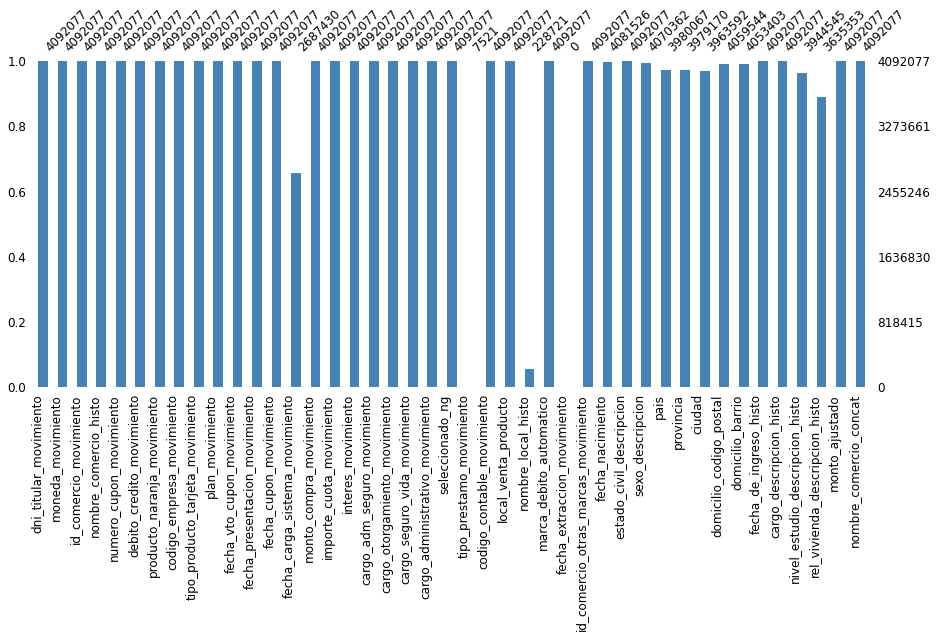

In [222]:
ax = msno.bar(df,figsize=(15, 6), fontsize=12, color='steelblue')
ax.tick_params('x', rotation=90)

In [223]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print('Porcentaje de valores en nulo:',"{:.0%}".format(total_missing/total_cells))

Porcentaje de valores en nulo: 8%


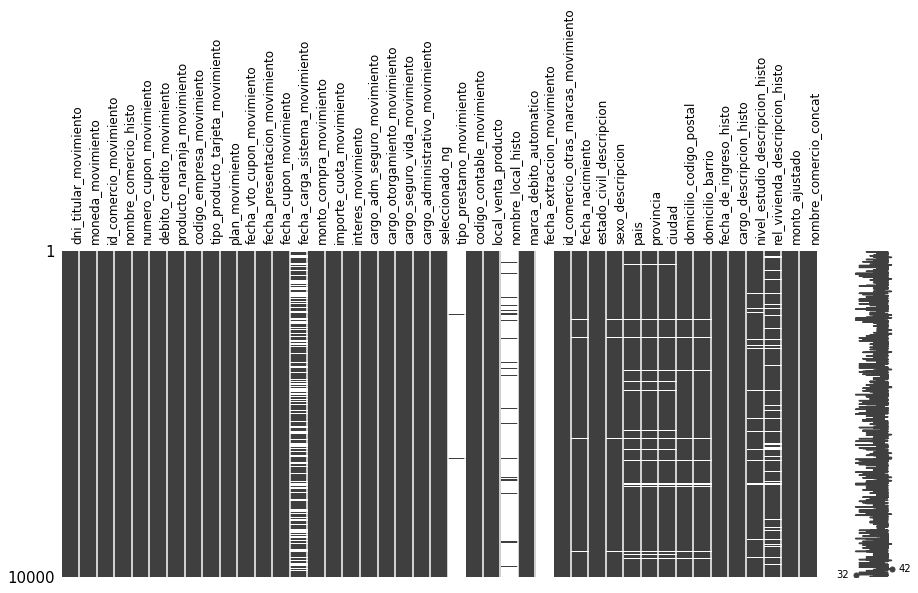

In [224]:
#usamos sample porque da error con todo el datas
df_ms = df.sample(10000)
ax = msno.matrix(df_ms,figsize=(15, 6),fontsize=12)
ax.tick_params('x', rotation=90)

Se puede observar cierta sistematicidad en la pérdida de valores relacionados a datos personales de los clientes. A continuación procedemos a analizar cada columna con valores faltantes.

#### Fecha carga sistema movimiento

In [229]:
print('fecha_cupon vs fecha_carga:')
df["fecha_cupon_movimiento"].corr(
    df["fecha_carga_sistema_movimiento"], method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_carga:


TypeError: reduction operation 'corr' not allowed for this dtype

A la hora de evaluar la reimputación de valores nulos en esta columna, decidimos, en primer lugar, considerar la utilidad que podriamos llegar a darle en un futuro. Al calcular su correlación con la columna **fecha_cupon_movimiento**, podemos observar que tienen una relación lineal fuerte, por lo cual decidimos no tener en cuenta esta columna para analisis posteriores.

In [76]:
df.drop('fecha_carga_sistema_movimiento', axis=1, inplace=True)

#### Tipo_prestamo_movimiento, Nombre_local_histo y Fecha_extraccion_movimiento 

Las variables tipo_prestamo_movimiento, nombre_local_histo y fecha_extraccion_movimiento poseen una pérdida muy alta de valores (fecha extracción tiene todos valores nulos), por lo cuál la mejor decisión seria no tenerlas en cuenta en los siguientes análisis.

In [77]:
df.drop(columns = ['tipo_prestamo_movimiento','nombre_local_histo','fecha_extraccion_movimiento'], inplace=True)

#### Datos Faltantes Personales de los clientes

In [78]:
col_pers = ['fecha_nacimiento', 'pais', 'domicilio_codigo_postal', 'sexo_descripcion',
           'provincia', 'dni_titular_movimiento', 'ciudad', 'edad_cliente', 'domicilio_barrio']

In [79]:
df_faltante_fech= pd.DataFrame(df[df['fecha_nacimiento'].isna()])
df_faltante_fech[col_pers].isna().sum()

fecha_nacimiento           10551
pais                       10551
domicilio_codigo_postal    10551
sexo_descripcion           10551
provincia                  10551
dni_titular_movimiento         0
ciudad                     10551
edad_cliente               10551
domicilio_barrio           10551
dtype: int64

In [80]:
df_faltante_fech.dni_titular_movimiento.value_counts()

000cde1ad5d8114e7a5dd977930b8835659    8481
000650e8144e3a42d47a21aee9e48f34804    1380
000b0d85fa8a959e2133328830fff990443     690
Name: dni_titular_movimiento, dtype: int64

In [81]:
dni859 = df[(df["dni_titular_movimiento"] =="000cde1ad5d8114e7a5dd977930b8835659")]
dni859.shape

(8481, 43)

In [82]:
dni804 = df[(df["dni_titular_movimiento"] =="000650e8144e3a42d47a21aee9e48f34804")]
dni804.shape

(1380, 43)

In [83]:
dni443 = df[(df["dni_titular_movimiento"] =="000b0d85fa8a959e2133328830fff990443")]
dni443.shape

(690, 43)

Se observa que son 3 los clientes que tienen valores faltantes en las columnas fecha_nacimiento, sexo_descripcion, pais, provincia, ciudad, domicilio_codigo_postal y domicilio_barrio. Corresponden a información personal de los mismos, que no puede ser recuperada de otra forma. Es una pérdida sistemática NMAR.

In [84]:
df_faltante_sexo = pd.DataFrame(df[df['sexo_descripcion'].isna()])
df_faltante_sexo[col_pers].isna().sum()

fecha_nacimiento           10551
pais                       11172
domicilio_codigo_postal    10551
sexo_descripcion           22888
provincia                  11172
dni_titular_movimiento         0
ciudad                     11172
edad_cliente               10551
domicilio_barrio           10551
dtype: int64

In [85]:
df_faltante_sexo.dni_titular_movimiento.value_counts()

000cde1ad5d8114e7a5dd977930b8835659    8481
000055175fe76d2c4b0ca52f904b0c0c903    8418
00017733df45bb08ee7abd44e6037cf7471    2263
000650e8144e3a42d47a21aee9e48f34804    1380
0006e947a6f89a8bcb835ae85c60ff93526    1035
000b0d85fa8a959e2133328830fff990443     690
000e5f85c3a5e3fe6dc1f214f01f55ae617     621
Name: dni_titular_movimiento, dtype: int64

In [86]:
dni903 = df[(df["dni_titular_movimiento"] =="000055175fe76d2c4b0ca52f904b0c0c903")]
dni903.shape

(8418, 43)

In [87]:
dni471 = df[(df["dni_titular_movimiento"] =="00017733df45bb08ee7abd44e6037cf7471")]
dni471.shape

(2263, 43)

In [88]:
dni526 = df[(df["dni_titular_movimiento"] =="0006e947a6f89a8bcb835ae85c60ff93526")]
dni526.shape

(1035, 43)

In [89]:
dni617 = df[(df["dni_titular_movimiento"] =="000e5f85c3a5e3fe6dc1f214f01f55ae617")]
dni617.shape

(621, 43)

Podemos decir que el resto de los dni a los que les falta el dato de sexo_descripcion tambien corresponden a una perdida sistematica, no puediendose recuperar dicho dato.

Procedemos a imputar con 'Sin Datos' a los valores faltantes en la columna sexo_descripcion.

In [90]:
columna = ['sexo_descripcion']
#df['sexo_descripcion']= df.sexo_descripcion.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= None, strategy='constant',fill_value="Sin Datos") 
df.loc[ : , columna] = pd.DataFrame(const_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

ValueError: Input contains NaN

In [ ]:
#df['sexo_descripcion'] = df['sexo_descripcion'].astype(str)
df['sexo_descripcion'].value_counts()

Procedemos a imputar usando IterativeImputer (en su operación por defecto BayesianRigde) la variable edad_cliente. Para imputar usamos las columnas **edad_cliente** y **antig_cliente**.

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp_columns = ['edad_cliente', 'antig_cliente']
x_train = df[imp_columns]
imp.fit(x_train)

x_test = df[imp_columns]
x_test = np.round(imp.transform(x_test))
x_test = pd.DataFrame(x_test, columns=imp_columns)
x_test

In [ ]:
df['edad_cliente'] = x_test['edad_cliente']

In [ ]:
df['edad_cliente'].describe().round(2)

La columna fecha_nacimiento se deja sin imputar debido a que su unica finalidad era obtener la edad del cliente. Por lo tanto, no se tiene en cuenta.

In [ ]:
df.drop('fecha_nacimiento', inplace=True, axis=1)

#### Datos Faltantes Geograficos de los clientes

In [ ]:
col_geo = ['domicilio_codigo_postal', 'pais', 'provincia', 'ciudad', 'domicilio_barrio']
df[df['domicilio_codigo_postal'].isna()][col_geo].isna().sum()

In [ ]:
df[df['domicilio_codigo_postal'].isna()].dni_titular_movimiento.value_counts()

In [ ]:
dni739 = df[(df["dni_titular_movimiento"] =="000ca38416fd465eb043954922c6b585739")]
dni739.shape

In [ ]:
dni037 = df[(df["dni_titular_movimiento"] =="000edf1f0ef2ba6fb1c639c4fb82133b037")]
dni037.shape

In [ ]:
dni238 = df[(df["dni_titular_movimiento"] =="0002ae4acf8215290b73530d4820e198238")]
dni238.shape

In [ ]:
dni765 = df[(df["dni_titular_movimiento"] =="00080a8a903ba92d2a2a4e0cc28fa9d8765")]
dni765.shape

In [ ]:
dni339 = df[(df["dni_titular_movimiento"] =="0009b382e7c4e4c8ec4a0b0459ca3ff6339")]
dni339.shape

In [ ]:
df.pais.value_counts()

Observamos la cantidad de provincias en nuestro dataframe

In [91]:
pd.DataFrame({'Provincias': df['provincia'].unique()})\
    .sort_values(by='Provincias',ascending=True)\
    .reset_index().drop(columns=['index'])

,Provincias
0,BUENOS AIRES
1,CAPITAL FEDERAL
2,CATAMARCA
3,CHACO
4,CHUBUT
5,CORDOBA
6,CORRIENTES
7,ENTRE RIOS
8,FORMOSA
9,JUJUY


Tenemos un total de 24 provincias y el resto, registros NaN.
Como todas las provincias son argentinas, observaremos la columna **pais** respecto a sus asociados. Tener en cuenta, que veremos los Nan/Nulos dentro de la mismas.

In [92]:
df['domicilio_codigo_postal'].unique()

array(['1766', '5521', '7107', '2200', '1019', '5700', '5280', '5501',
       '3600', '1744', '2000', '3500', '1625', '8355', '2132', '1891',
       '1419', '8300', '5570', '4700', '9420', '3409', '2630', '1874',
       '1900', '4634', '3000', '4400', '5903', '5006', '2002', '5300',
       '2400', '6000', '3450', '1826', '4152', '5442', '5800', '4230',
       '3400', '8336', '5513', '5000', '5577', '5004', '1824', '4000',
       '8430', '1214', '8340', '5900', '1914', '5519', '3300', '5014',
       '5236', '4415', '5413', '5001', '1408', '5509', '1120', '7165',
       '5013', '1619', '3100', '8318', '2006', '4401', '1648', '4119',
       nan, '5021', '3200', '5008', '9210', '1878', '5573', '5803',
       '5980', '2008', '5016', '5541', '5152', '5214', '1028', '5223',
       '1650', '5022', '2918', '3706', '4101', '4200', '5825', '7600',
       '5500', '5196', '3560', '4308', '4174', '5109', '4600', '9000',
       '5535', '5123', '5017', '6300', '5012', '3730', '5009', '1832',
       '5

Podemos observar que tenemos un 0, por lo que haremos un análisis más profundo sobre esta columna.

In [93]:
df[df['domicilio_codigo_postal'].str.len()<4][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

,pais,provincia,ciudad,domicilio_codigo_postal
857287,Argentina,NaN,NaN,0
2140261,Argentina,TUCUMAN,CAMPO HERRERA,400


Observamos que tenemos 2 códigos postales con 0 y con 400. Observemos si podemos recuperar el código postal de la localidad de **Campo Herrera**. El Código Postal en 0, lo dejaremos en NaN.

In [94]:
print('Cantidad de filas con Cero:', len(df[df['domicilio_codigo_postal']=='0']))
df[df['domicilio_codigo_postal']=='0'].head()

Cantidad de filas con Cero: 897


,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat
857287,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,1985-04-09,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36,0,020
857980,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,1985-04-09,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36,0,020
858673,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,1985-04-09,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36,0,020
859366,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,1985-04-09,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36,0,020
860059,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,1985-04-09,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36,0,020


In [95]:
df['domicilio_codigo_postal'] = df['domicilio_codigo_postal'].replace('0',np.nan)
df[df['domicilio_codigo_postal']=='0']

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


In [96]:
df['ciudad'] = df['ciudad'].str.strip()
print('Cantidad de filas con 400 en el CP:',len(df[df['ciudad'].isin(['CAMPO HERRERA'])]))
df[df['ciudad'].isin(['CAMPO HERRERA'])][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

Cantidad de filas con 400 en el CP: 690


,pais,provincia,ciudad,domicilio_codigo_postal
2140261,Argentina,TUCUMAN,CAMPO HERRERA,400


La provincia **TUCUMAN** - Ciudad **CAMPO HERRERA**, al ser un caso erroneo y ser único, se imputará el valor a mano.

Fuente: [link]('https://codigo-postal.co/argentina/tucuman/campo-herrera/')

In [97]:
df.loc[df['ciudad'].isin(['CAMPO HERRERA']),'domicilio_codigo_postal'] = '4105'
print('Cantidad de filas con 400 en el CP:',len(df[df['ciudad'].isin(['CAMPO HERRERA'])]))
df[df['ciudad'].isin(['CAMPO HERRERA'])][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

Cantidad de filas con 400 en el CP: 690


,pais,provincia,ciudad,domicilio_codigo_postal
2140261,Argentina,TUCUMAN,CAMPO HERRERA,4105


Seguimos con el análisis cuando el país sea nulo

In [98]:
df[df['pais'].isnull() == True][['pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio']].drop_duplicates()

,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio
2674,NaN,NaN,NaN,5000,SAN VICENTE
2691,NaN,NaN,NaN,NaN,NaN
2763,NaN,NaN,NaN,5501,FUCHS 1
47711,NaN,NaN,NaN,5613,MALARGUE
47757,NaN,NaN,NaN,5800,VALACO
69580,NaN,NaN,NaN,4146,CONCEPCION
77981,NaN,NaN,NaN,2144,TOTORAS
78121,NaN,NaN,NaN,5907,SILVIO PELLICO
90122,NaN,NaN,NaN,1663,SARMIENTO
90159,NaN,NaN,NaN,8322,RUCA QUIMEY


Tenemos pais, provincia, y ciudad que son nulas cuando el país es nulo.

Primero intentaremos imputar por el mismo Datasets.

In [99]:
df[(df['domicilio_codigo_postal'].isna()==True) & (df['ciudad'].isna()!=True)]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


In [100]:
df[(df['domicilio_codigo_postal'].isna()==True) & (df['provincia'].isna()!=True)]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


Por lo que podemos observar, no podemos imputar el código postal ni por la columna **ciudad** ni la columna **provincia**.

In [101]:
df[(df['domicilio_codigo_postal'].isna()!=True) & (df['ciudad'].isna()==True)][['domicilio_codigo_postal','ciudad']].drop_duplicates()

,domicilio_codigo_postal,ciudad
2623,4400,NaN
2674,5000,NaN
2763,5501,NaN
13626,5101,NaN
47711,5613,NaN
47757,5800,NaN
69580,4146,NaN
77981,2144,NaN
78121,5907,NaN
90122,1663,NaN


Guardaremos estos Códigos Postales dentro de un Array para ver si se pueden auto-imputar.

In [102]:
cp_ciu_nan = df[(df['domicilio_codigo_postal'].isna()!=True) & (df['ciudad'].isna()==True)]['domicilio_codigo_postal'].unique()
df[df['domicilio_codigo_postal'].isin(cp_ciu_nan)][['domicilio_codigo_postal','ciudad']]\
.drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,ciudad
212130,1130,NaN
104398,1663,SAN MIGUEL
90122,1663,NaN
77981,2144,NaN
2140268,2506,NaN
2140342,2705,NaN
625076,2812,NaN
810350,3230,NaN
2140278,3240,NaN
2662,3300,POSADAS


Como podemos ver, podemos realizar una auto-imputación de ciudades

In [103]:
df.loc[:,'ciudad'] = df['ciudad'].str.upper()
df_dp_cd = df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['ciudad'].isna()==False)]\
            [['domicilio_codigo_postal','ciudad']]\
            .drop_duplicates()\
            .sort_values(by=['domicilio_codigo_postal'])
df_dp_cd = df_dp_cd.rename(columns={'ciudad': 'ciudad_0', 'domicilio_codigo_postal': 'cp'})
df_dp_cd

,cp,ciudad_0
104398,1663,SAN MIGUEL
2662,3300,POSADAS
897,3500,RESISTENCIA
24722,3503,LA LEONESA
2651,4000,SAN MIGUEL DE TUCUMAN
69493,4000,TUCUMAN
2720,4101,SAN MIGUEL DE TUCUMAN
24647,4101,LAS TALITASTUCUMAN
2635,4400,SALTA
2646,5000,CORDOBA


Realizamos Merge sobre el dataframe creado, e imputamos los datos.

In [104]:
df = df.merge(df_dp_cd, 
              how='left',
              left_on = 'domicilio_codigo_postal', 
              right_on = 'cp')\
            .drop(columns= ['cp'])
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,ciudad_0
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,1959-07-18,Divorciadoa,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMPDE COMERCIO,SECUNDARIOS,Propia,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61,92,020,NaN
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VANVA DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,15.68,INTERES POR MORA US,Sector_Sin_Datos,29,2,020,NaN
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,1992-07-29,Solteroa,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,5.46,INTERES POR MORA US,Sector_Sin_Datos,28,95,020,NaN
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,1980-11-01,Solteroa,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMPDE COMERCIO,SECUNDARIOS,Propia,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40,151,020,NaN
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,1984-03-08,Solteroa,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMPDE COMERCIO,UNIVERSITARIOS,Alquilada,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36,86,020,NaN


In [118]:
# Sustituimos los valores nulos de la columna provincia (provincia_x) por las provincias (en mayus) de la columna
# provincia creada en la anterior unión.
df.loc[df['ciudad'].isnull(), 'ciudad'] = df['ciudad_0'].str.upper()

df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['ciudad'].isna()==True)]\
    [['domicilio_codigo_postal','ciudad','ciudad_0']].drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,ciudad,ciudad_0
218273,1130,NaN,NaN
80258,2144,NaN,NaN
2211267,2506,NaN,NaN
2211341,2705,NaN,NaN
642876,2812,NaN,NaN
833886,3230,NaN,NaN
2211277,3240,NaN,NaN
71584,4146,NaN,NaN
2211285,5019,NaN,NaN
14112,5101,NaN,NaN


In [120]:
df = df.drop(columns=['ciudad_0'])

Imputamos **provincia** de la misma forma que **ciudad**

In [121]:
cp_prov_nan = df[(df['domicilio_codigo_postal'].isna()!=True) & (df['provincia'].isna()==True)]['domicilio_codigo_postal'].unique()
df[df['domicilio_codigo_postal'].isin(cp_prov_nan)][['domicilio_codigo_postal','provincia']]\
.drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,provincia
218273,1130,NaN
107572,1663,BUENOS AIRES
92816,1663,NaN
80258,2144,NaN
2211341,2705,NaN
642876,2812,NaN
833886,3230,NaN
2663,3300,MISIONES
882204,3300,NaN
897,3500,CHACO


In [124]:
df.loc[:,'provincia'] = df['provincia'].str.upper()
df_dp_pv = df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['provincia'].isna()==False)]\
            [['domicilio_codigo_postal','provincia']]\
            .drop_duplicates()\
            .sort_values(by=['domicilio_codigo_postal'])
df_dp_pv = df_dp_pv.rename(columns={'provincia': 'provincia_0', 'domicilio_codigo_postal': 'cp'})
df_dp_pv

,cp,provincia_0
107572,1663,BUENOS AIRES
2211267,2506,SANTA FE
2211277,3240,ENTRE RIOS
2663,3300,MISIONES
897,3500,CHACO
25485,3503,CHACO
2651,4000,TUCUMAN
2724,4101,TUCUMAN
2623,4400,SALTA
2646,5000,CORDOBA


In [125]:
df = df.merge(df_dp_pv, 
              how='left',
              left_on = 'domicilio_codigo_postal', 
              right_on = 'cp')\
            .drop(columns= ['cp'])
df.head()

MemoryError: Unable to allocate 670. MiB for an array with shape (19, 4622506) and data type object

In [118]:
# Sustituimos los valores nulos de la columna provincia (provincia_x) por las provincias (en mayus) de la columna
# provincia creada en la anterior unión.
df.loc[df['provincia'].isnull(), 'provincia'] = df['provincia_0'].str.upper()

df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['provincia'].isna()==True)]\
    [['domicilio_codigo_postal','provincia','provincia_0']].drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,ciudad,ciudad_0
218273,1130,NaN,NaN
80258,2144,NaN,NaN
2211267,2506,NaN,NaN
2211341,2705,NaN,NaN
642876,2812,NaN,NaN
833886,3230,NaN,NaN
2211277,3240,NaN,NaN
71584,4146,NaN,NaN
2211285,5019,NaN,NaN
14112,5101,NaN,NaN


In [ ]:
df = df.drop(columns=['provincia_0'])

Hacemos una lectura de un CSV con Códigos Postales, Localidades y Provincias de Argentina.

In [126]:
df_cp = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/localidades_AR/master/localidades_cp_maestro.csv')
df_cp.head()

,provincia,id,localidad,cp,id_prov_mstr
0,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,NaN,2
1,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1144.0,2
2,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1145.0,2
3,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1146.0,2
4,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1147.0,2


Realizamos una curación de datos sobre este dataset.

In [127]:
df_cp.cp = df_cp[df_cp['cp'].isna()!=True]['cp'].apply(int).apply(str)
df_cp.head()

,provincia,id,localidad,cp,id_prov_mstr
0,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,NaN,2
1,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1144,2
2,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1145,2
3,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1146,2
4,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1147,2


Observamos si todos los Códigos Postales de nuestro DataFrame original se encuentran en los objetos del merge.

In [128]:
df_cp = df_cp[~df_cp['cp'].isnull()]
df_cp.isna().sum()

provincia       0
id              0
localidad       0
cp              0
id_prov_mstr    0
dtype: int64

In [129]:
pd.DataFrame({'Provincias': df_cp['provincia'].unique()})\
    .sort_values(by='Provincias',ascending=True)\
    .reset_index().drop(columns=['index'])

,Provincias
0,Buenos Aires
1,Catamarca
2,Chaco
3,Chubut
4,Ciudad Autonoma de Buenos Aires
5,Cordoba
6,Corrientes
7,Entre Rios
8,Formosa
9,Jujuy


In [130]:
df_cp.loc[df_cp['provincia'] == 'Ciudad Autonoma de Buenos Aires', 'provincia'] = 'CAPITAL FEDERAL'
df_cp.loc[df_cp['provincia'] == 'Santiago del Estero', 'provincia'] = 'SGO DEL ESTERO'
df_cp['provincia'].unique()

array(['CAPITAL FEDERAL', 'Buenos Aires', 'Catamarca', 'Cordoba',
       'Corrientes', 'Chaco', 'Chubut', 'Entre Rios', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquen',
       'Rio Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz',
       'Santa Fe', 'SGO DEL ESTERO', 'Tucuman', 'Tierra del Fuego'],
      dtype=object)

In [131]:
df_cp.loc[:,'provincia'] = df_cp['provincia'].str.upper()
df_cp.loc[:,'localidad'] = df_cp['localidad'].str.upper()
df_cp[['provincia','localidad']].drop_duplicates()

,provincia,localidad
1,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES
456,BUENOS AIRES,COLONIA VELEZ
457,BUENOS AIRES,SPURR
458,BUENOS AIRES,SPERONI
459,BUENOS AIRES,SPERATTI
...,...,...
23234,TIERRA DEL FUEGO,ESTANCIA SAN JULIO
23235,TIERRA DEL FUEGO,ESTANCIA SAN JUSTO
23236,TIERRA DEL FUEGO,ESTANCIA SAN MARTIN
23237,TIERRA DEL FUEGO,ESTANCIA RIO EWAN


In [132]:
df_cp = df_cp.rename(columns={'provincia': 'provincia_0'})
df_cp.head()

,provincia_0,id,localidad,cp,id_prov_mstr
1,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1144,2
2,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1145,2
3,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1146,2
4,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1147,2
5,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1148,2


In [133]:
df.shape

(4622506, 43)

Procedemos a hacer el merge de los datasets, a través de la columna cp (Codigo Postal)

In [ ]:
# Unimos por cp, eliminamos duplicados, conservamos solo cps del dataframe original
df = df.merge(df_cp[['provincia_0','localidad','cp']].drop_duplicates(subset=['cp'], keep='first'), 
                           how='left',
                           left_on = 'domicilio_codigo_postal', 
                           right_on = 'cp')\
                    .drop(columns= ['cp'])
df.head()

In [ ]:
df.loc[df['provincia'].isnull(), 'provincia'] = df['provincia_0'].str.upper()
df.loc[df['ciudad'].isnull(), 'ciudad'] = df['localidad'].str.upper()

In [ ]:
df = df.drop(columns=['provincia_0','localidad'])

#### Datos faltantes Nivel de Estudio

In [ ]:
df.nivel_estudio_descripcion_histo.value_counts()

In [ ]:
columna = ['nivel_estudio_descripcion_histo']
#df["nivel_estudio_descripcion_histo"]= df.nivel_estudio_descripcion_histo.fillna(value=np.nan)
frec_imputer = SimpleImputer(missing_values = None, strategy='most_frequent')
df.loc[ : , columna] = pd.DataFrame(frec_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [ ]:
df.nivel_estudio_descripcion_histo.value_counts()

Se imputaron los valores nulos del nivel de estudio utilizando SimpleImputer con estrategia 'mas frecuente'

#### Datos faltantes Vivienda

In [ ]:
df.rel_vivienda_descripcion_histo.value_counts()

In [ ]:
columna = ['rel_vivienda_descripcion_histo']
#df["nivel_estudio_descripcion_histo"]= df.nivel_estudio_descripcion_histo.fillna(value=np.nan)
frec_imputer = SimpleImputer(missing_values = None, strategy='most_frequent')
df.loc[ : , columna] = pd.DataFrame(frec_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [ ]:
df.rel_vivienda_descripcion_histo.value_counts()

Se imputaron los valores nulos de la vivienda utilizando SimpleImputer con estrategia 'mas frecuente'

In [ ]:
df.isna().sum()

### 3.2 Valores Atípicos

### Valores atipicos en fechas

Veremos las relaciones entre las distintas columnas de fecha para ver si podemos descartar algunas.

In [ ]:
print('fecha_cupon vs fecha_presentacion:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df["fecha_presentacion_movimiento"].dt.date, method = 'spearman', min_periods = 1)

In [ ]:
print('fecha_cupon vs fecha_vto:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df['fecha_vto_cupon_movimiento'].dt.date, method = 'spearman', min_periods = 1)

Para las variables fecha_carga_sistema_movimiento, fecha_presentacion_movimiento, fecha_vto_cupon_movimiento; el calculo numerico de la correlacion es muy alto con la variable fecha_cupon_movimiento. Esto tiene sentido si consideramos que la carga al sistema, la presentacion y el vencimiento estan conceptualmente relacionados al cupon o la factura. Teniendo en cuenta esto decidimos eliminar del dataset a estas variables, dejando unicamente a fecha_cupon. 

In [ ]:
df.drop(["fecha_carga_sistema_movimiento", "fecha_presentacion_movimiento", "fecha_vto_cupon_movimiento"], axis=1, inplace=True)

In [ ]:
fecha = 'fecha_cupon_movimiento'

fig, ax = plt.subplots(figsize=(14,7))
ax.tick_params(axis='x',rotation = 45,labelsize = 13)
ax.set_xlabel("Fecha de compra")
ax.set_yscale("log")
sns.histplot(data=df, x=fecha, bins=80, color="#3182bd", alpha=0.5)
ax.set_title('Histograma de frecuencia para fecha de cupón')

El grafico nos demuestra que existen algunos casos aislados desde Marzo hasta Julio. Decidimos eliminar estos casos aislados para que en todos los meses analizados exista una cantidad significativa de datos. 

In [ ]:
print('Cantidad de casos antes de Abril 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-04-01')]))
print('Cantidad de casos antes de Mayo 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-05-01')]))
print('Cantidad de casos antes de Junio 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-06-01')]))
print('Cantidad de casos antes de Julio 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-07-01')]))
print('Cantidad de casos antes de Agosto 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-08-01')]))

In [ ]:
print('Cantidad de casos despues de Abril 2021: ', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-04-01')]))
print('Cantidad de casos despues de Mayo 2021: ', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-05-01')]))
print('Cantidad de casos despues de Junio 2021: ', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-06-01')]))

Desde el mes de agosto la cantidad de casos aumenta significativamente en comparacion con los meses anteriores. Para conservar los meses donde hay suficientes transacciones como para obtener datos significativos en las tendencias, filtramos los datos anteriores a Agosto.

Haciendo un calculo similar a los ultimos meses, 

In [ ]:
df.loc[:, :] = df[df['fecha_cupon_movimiento'] >= pd.to_datetime('2020-08-01')]
df.loc[:, :] = df[df['fecha_cupon_movimiento'] < pd.to_datetime('2021-06-01')]

### Creacion de dataset a guardar

In [ ]:
# Aca diria que esten todas las operaciones de ppio a fin

### ¿Se puede normalizar la antiguedad y/o monto_compra_movimiento?

In [ ]:
#scaled_df = pd.DataFrame(
colums_norm = ["monto_compra_movimiento","antig_cliente"] 
df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df[colums_norm])).rename(columns={'0': 'monto_compra_movimiento', '1': 'antig_cliente'})
df_scaled 

In [ ]:
monto = df.monto_compra_movimiento.values.copy().reshape(-1,1)
antig = df.antig_cliente.values.copy().reshape(-1,1)
monto_scaled = MinMaxScaler().fit_transform(monto)
antig_scaled = MinMaxScaler().fit_transform(antig)

In [ ]:
fig, ax=plt.subplots(1,2)
sns.distplot(monto,ax=ax[0],color='Green')
ax[0].set_title("Monto sin escalar")
sns.distplot(monto_scaled, ax=ax[1])
ax[1].set_title("Monto escalado")

In [ ]:
fig, ax=plt.subplots(1,2)
sns.distplot(antig,ax=ax[0],color='Green')
ax[0].set_title("Antiguedad sin escalar")
sns.distplot(antig_scaled, ax=ax[1])
ax[1].set_title("Antiguedad escalado")

### Análisis del PCA

Primero se debe procesar las columnas antes de aplicar el PCA, es decir dejarlas en formato de matríz. Intentamos el cálculo sin estandarizar..

In [ ]:
colum_pca = ["monto_compra_movimiento", "edad_cliente","antig_cliente"] 

In [ ]:
df_pca = df[colum_pca]
df_pca = (df_pca).dropna(subset=['edad_cliente'])

In [ ]:
df_pca = df_pca.values
df_pca

In [ ]:
pca = PCA(n_components=3)
pca.fit(df_pca)
proyected_features = pca.transform(df_pca)
proyected_features.shape

In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

In [ ]:
acc_variance_percent = np.cumsum(np.round(explained_variance, decimals=4) * 100)
acc_variance_percent

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(pca.n_components))
plt.plot(acc_variance_percent)

In [ ]:
acc_variance_percent = np.cumsum(np.round(explained_variance, decimals=4) * 100)
acc_variance_percent

Sin estandarizar las variables no llego a encontrar un componente principal.. 

#### Estandarizar/Normalizar antes

In [ ]:
df_pca_stand = preprocessing.StandardScaler().fit_transform(df_pca)
df_pca_stand

In [ ]:
pca2 = PCA(n_components=3)
pca2.fit(df_pca_stand)
proyected_features_2 = pca2.transform(df_pca_stand)
proyected_features_2.shape

In [ ]:
explained_variance_2 = pca2.explained_variance_ratio_
explained_variance_2

In [ ]:
acc_variance_percent_2 = np.cumsum(np.round(explained_variance_2, decimals=4) * 100)
acc_variance_percent_2

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(pca2.n_components))
plt.plot(acc_variance_percent_2)

In [ ]:
df_pca_final = df[colum_pca]
df_pca_final = (df_pca_final).dropna(subset=['edad_cliente'])
df_pca_final[["pca1","pca2"]] = proyected_features_2[:,:2]
df_pca_final

In [ ]:
cols = ['edad_cliente', 'antig_cliente']
data = df_pca_final[cols + ['pca1', 'pca2']][:1000].dropna(how='any')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='edad_cliente', ax=axes[0])  
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='antig_cliente', ax=axes[1]) 

## 4. Guardado
* Eliminar las columnas/filas que se concideren no necesarias, explicando el por que
* Codificar variables: todas las variables categóricas deben guardarse como variables numéricas, no string
* Comprimir el conjunto de datos para que se guarde en el formato más eficiente y comparalo contra `csv`.

## 5. Optativos
En Big data se manejan datos crudos todo el tiempo y de gran volumen, este proceso de exploracion y limpieza
es parte del proceso conocido como ETL (Extract, transform, load) o ELT (Extract, load, transform). 
Todo el proceso de este tp pertenece a la etapa de Transfom. En big data esto se hace de manera automatizada. 

* Entonces como asegurarse que los datos son saludables?.
  Es decir que no contengan valores atipicos, nulls, tipos de datos incorrectos, etc.
  No podemos hacer validaciones a mano si tenemos miles de datos por dia/hora.
  > Hint: [great expectations](https://greatexpectations.io/)
* Documentar las columnas finales. (procesos aplicados en este tp)
